# Airbus Ship Detection Dataset

## Description of the dataset

Many images do not contain ships, and those that do may contain multiple ships. Ships within and across images may differ in size (sometimes significantly) and be located in open sea, at docks, marinas, etc.

For this metric, object segments cannot overlap. There were a small percentage of images in both the Train and Test set that had slight overlap of object segments when ships were directly next to each other. Any segments overlaps were removed by setting them to background (i.e., non-ship) encoding. Therefore, some images have a ground truth may be an aligned bounding box with some pixels removed from an edge of the segment. These small adjustments will have a minimal impact on scoring, since the scoring evaluates over increasing overlap thresholds.

The train_ship_segmentations.csv file provides the ground truth (in run-length encoding format) for the training images.

The sample_submission files contains the images in the test images.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

EncodedPixels - a list of pixels for ship segmentation in a compressed format (in run-length encoding format).

EncodedPixels сonsists of pairs of values that contain a start position and a run length. E.g. '1 3' implies starting at pixel 1 and running a total of 3 pixels (1,2,3).

The pixels are one-indexed and numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc.

A prediction  of "no ship in image" have a blank value in the EncodedPixels column.

Object segments do not overlap.

In [2]:
segmentations = pd.read_csv("C:/Users//Valentina/Desktop/Airbus Ship Detection/input/train_ship_segmentations_v2.csv")
segmentations['EncodedPixels'] = segmentations['EncodedPixels'].astype('string')

## Feature Extraction
- ImageHeight - image height
- ImageWidth - image weight
- ShipAreaPercentage - percentage of the ship segmentation area in the image. Measured as a percentage, from 0 to 100%

In [3]:
def get_train_image(name: str):
    path = f'C:/Users//Valentina/Desktop/Airbus Ship Detection/input/train_v2/{name}'
    return cv2.imread(path)

def extract_features_from_image(row: pd.Series) -> pd.Series:
    image = np.zeros((768, 768, 3))# get_train_image(row['ImageId'])
    row['ImageHeight'], row['ImageWidth'], _ = image.shape
    return row

segmentations = segmentations.apply(lambda x: extract_features_from_image(x), axis=1)

In [4]:
def pixels_number(encoded_pixels: str) -> int:
    if pd.isna(encoded_pixels):
        return 0
    return np.array(encoded_pixels.split()[1::2], dtype=int).sum()

segmentations['ShipAreaPercentage'] = segmentations.apply(lambda x: pixels_number(x['EncodedPixels']) / (x['ImageHeight'] * x['ImageWidth']) * 100, axis=1)

## Exploring the data

In [5]:
print(f'There are {segmentations.shape[0]} rows.')
segmentations.head(15)

There are 231723 rows.


,ImageId,EncodedPixels,ImageHeight,ImageWidth,ShipAreaPercentage
0,00003e153.jpg,<NA>,768,768,0.000000
1,0001124c7.jpg,<NA>,768,768,0.000000
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,768,768,0.574409
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,768,768,0.030009
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,768,768,0.025092
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...,768,768,0.081380
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...,768,768,0.001187
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...,768,768,0.109863
8,0001b1832.jpg,<NA>,768,768,0.000000
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...,768,768,0.067817


In [6]:
train_images_number = segmentations['ImageId'].nunique()
print(f'There are {train_images_number} train images.')

There are 192556 train images.


## Image resolution

In [7]:
print(segmentations['ImageHeight'].value_counts())
print(segmentations['ImageWidth'].value_counts())

768    231723
Name: ImageHeight, dtype: int64
768    231723
Name: ImageWidth, dtype: int64


## Distribution of the number of ships in images

In [8]:
images_without_ships = segmentations['EncodedPixels'].isna().sum()
print(f'There are {images_without_ships} images without ships.')

There are 150000 images without ships.


ShipCount
0            150000
1             27104
2              7674
3              2954
4              1622
5               925
6               657
7               406
8               318
9               243
10              168
11              144
12              124
14               76
13               75
15               66
dtype: int64


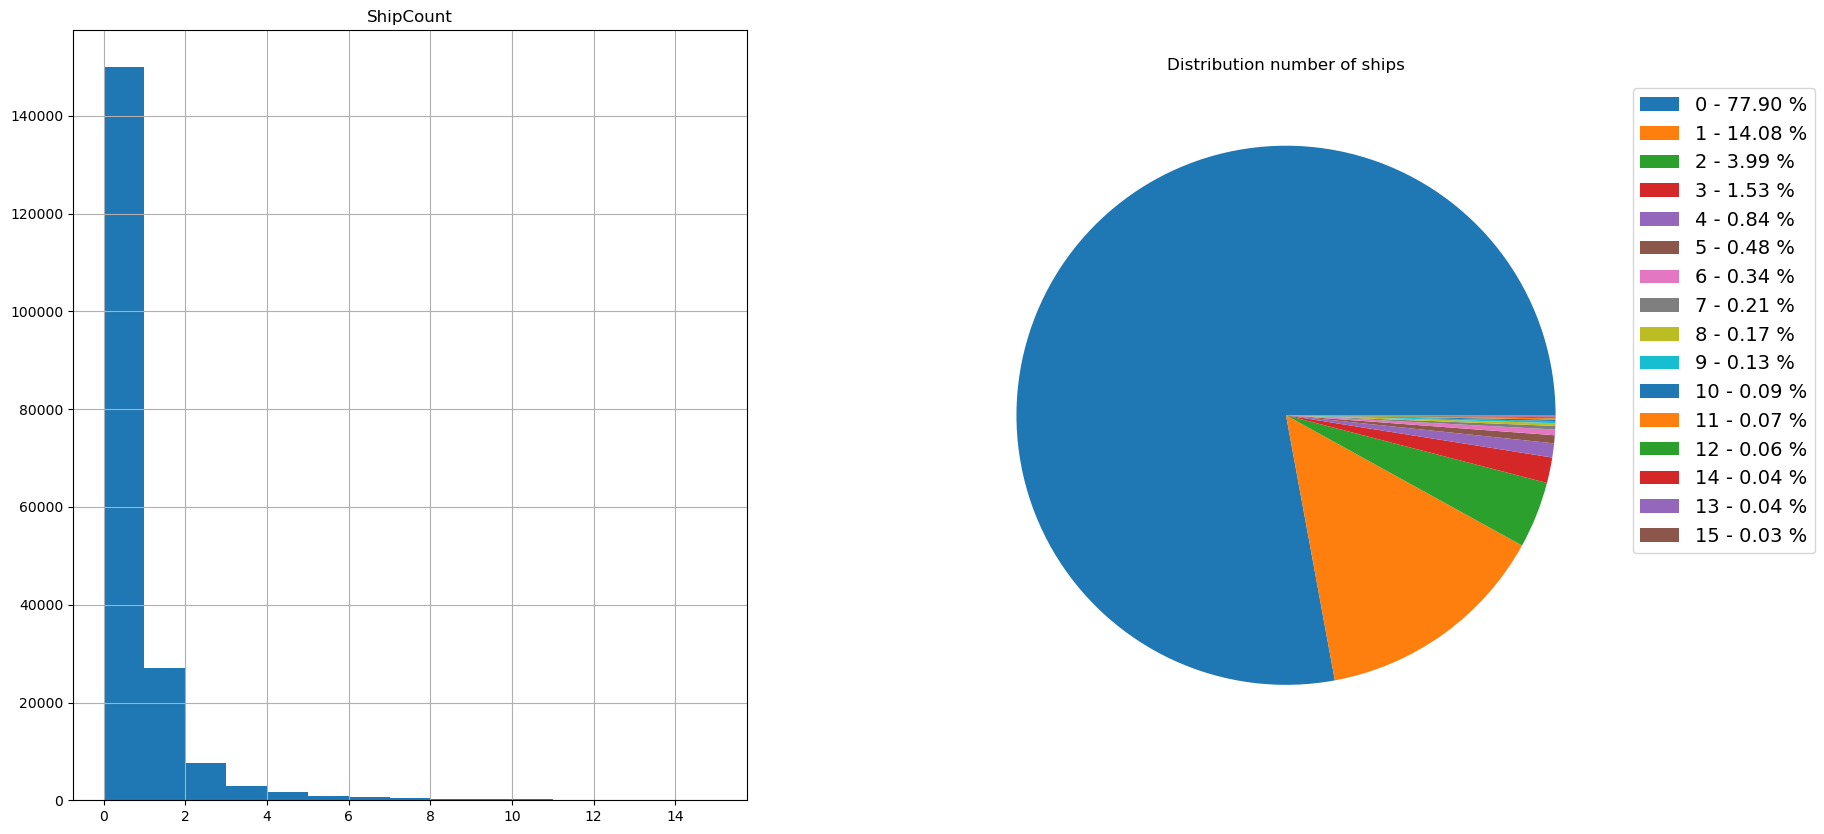

In [9]:
segmentations['ShipCount'] = segmentations.apply(lambda x: 0 if pd.isna(x['EncodedPixels']) else 1, axis=1)
ships_numbers = segmentations[['ImageId','ShipCount']].groupby(['ImageId']).sum()
print(ships_numbers.value_counts())

f,ax=plt.subplots(1, 2,figsize=(20,10))

ships_numbers.hist(bins = 15, ax=ax[0])

y = ships_numbers.value_counts().values
percent = 100.*y/y.sum()
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(ships_numbers.value_counts().index.get_level_values(0), percent)]
ships_numbers.value_counts().plot.pie(labels=None, ax=ax[1])
ax[1].legend(labels, bbox_to_anchor=(1., 1.), fontsize=14)
ax[1].yaxis.set_visible(False)
ax[1].set_title('Distribution number of ships')

plt.show()

Almost 78% of images don't have any ships. Only 14% have one ship. And on the remaining 8% of the images there are from 2 to 15 ships.

## Ship segmentation area distribution

Text(0.5, 0, '')

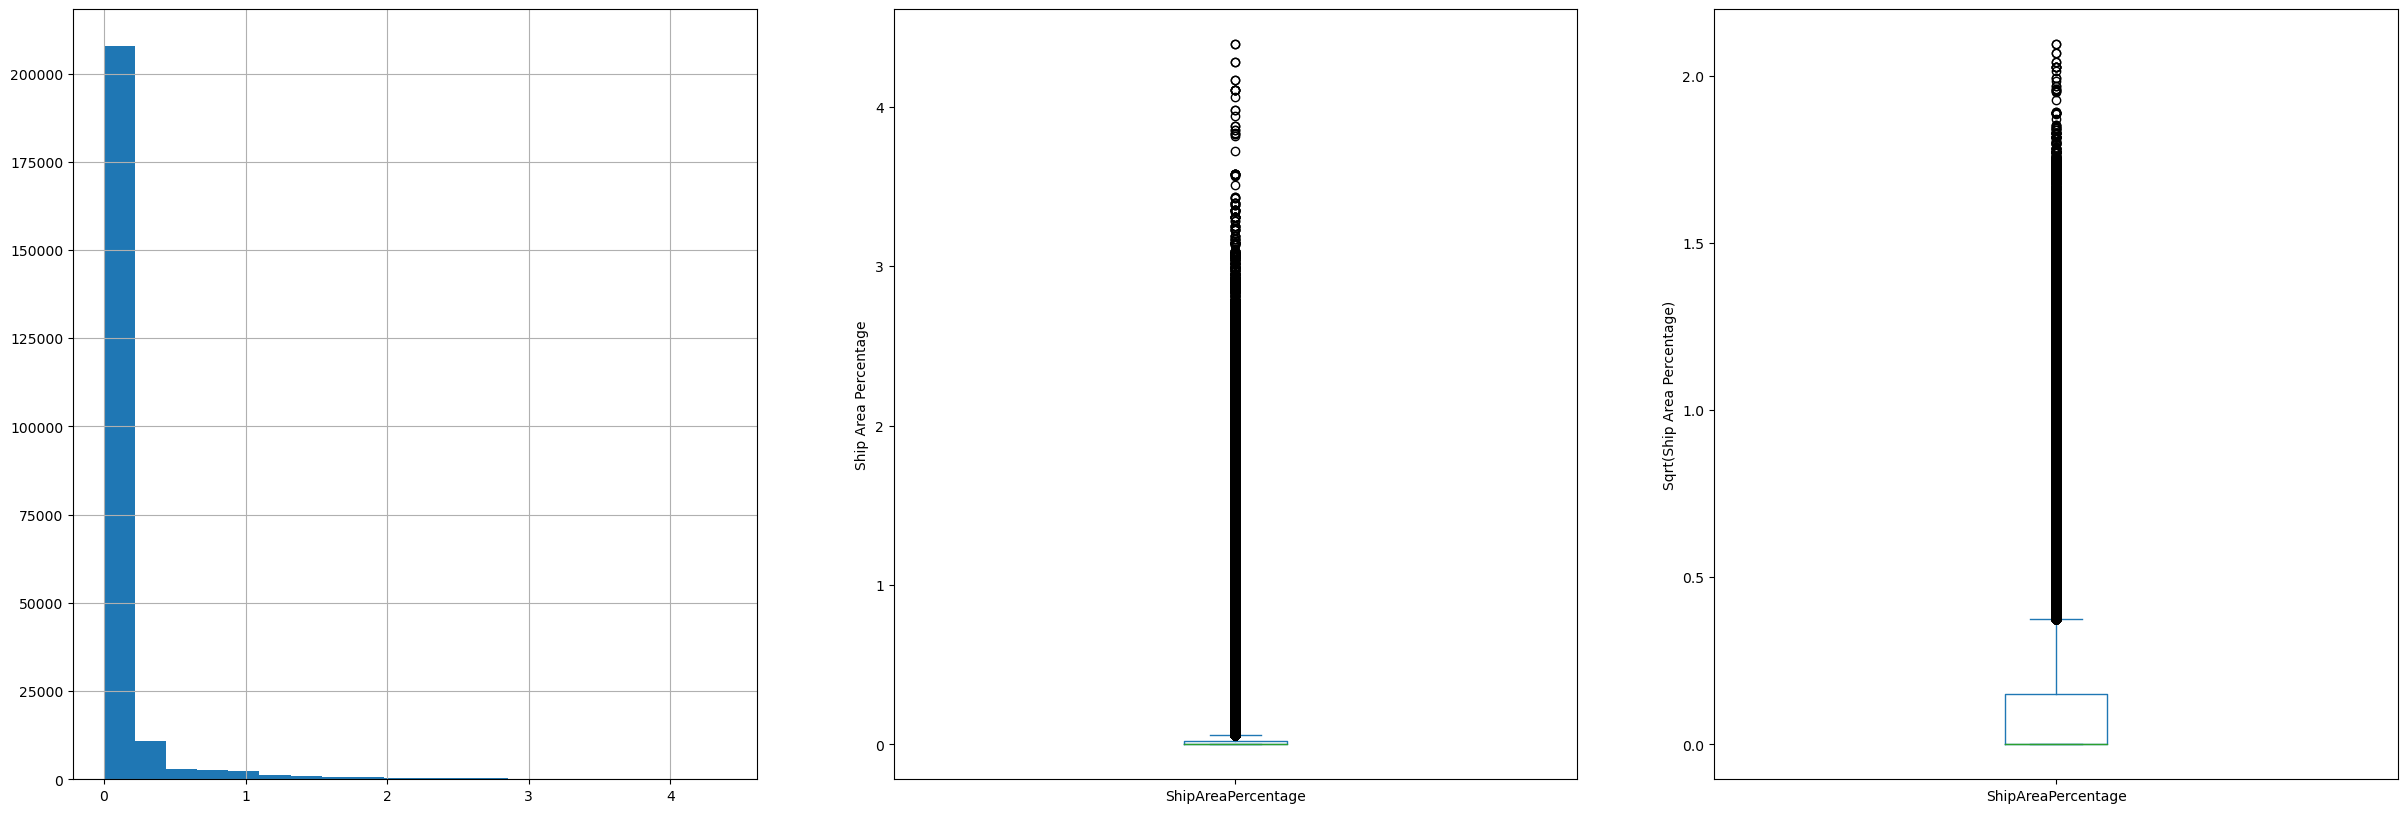

In [10]:
f,ax=plt.subplots(1, 3,figsize=(30,10))

segmentations['ShipAreaPercentage'].hist(bins=20, ax=ax[0])
segmentations['ShipAreaPercentage'].plot.box(ax=ax[1])
ax[1].set_ylabel('Ship Area Percentage')
ax[1].set_xlabel('')
segmentations['ShipAreaPercentage'].apply(lambda x: x ** 0.5).plot.box(ax=ax[2])
ax[2].set_ylabel('Sqrt(Ship Area Percentage)')
ax[2].set_xlabel('')

All ships are very small in the images. Ships occupy no more than 4% of the image. Most of the ships take up less than 0.1% of the image.

## Display ship segmentation pixels

In [11]:
def show_image_with_encoded_pixels(image_id: str):
    rows = segmentations[segmentations['ImageId'] == image_id]
    if len(rows) == 0:
        return
    
    image = get_train_image(image_id)
    image_size, _, _ = image.shape
    ship_count = len(rows)
    all_ships = np.zeros_like(image)

    ax_rows_number = ship_count + 1
    f,ax = plt.subplots(ax_rows_number, 3, figsize=(15, 5 * ax_rows_number))

    for i in range(ship_count):
        image_info = rows.iloc[i]

        encoded_pixels = np.array(image_info['EncodedPixels'].split(), dtype=int)
        pixels, shift = encoded_pixels[::2], encoded_pixels[1::2]
        ship = np.zeros_like(image)

        for pixel, shift in zip(pixels, shift):
            for j in range(shift):
                cur_pixel = pixel + j - 1
                ship[cur_pixel % image_size, cur_pixel // image_size] = [255, 255, 255]
        all_ships += ship
        
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(ship)
        ax[i, 2].imshow(image * (ship // 255))
        
    ax[ship_count, 0].imshow(image)
    ax[ship_count, 1].imshow(all_ships)
    ax[ship_count, 2].imshow(image * (all_ships // 255))
    plt.show()

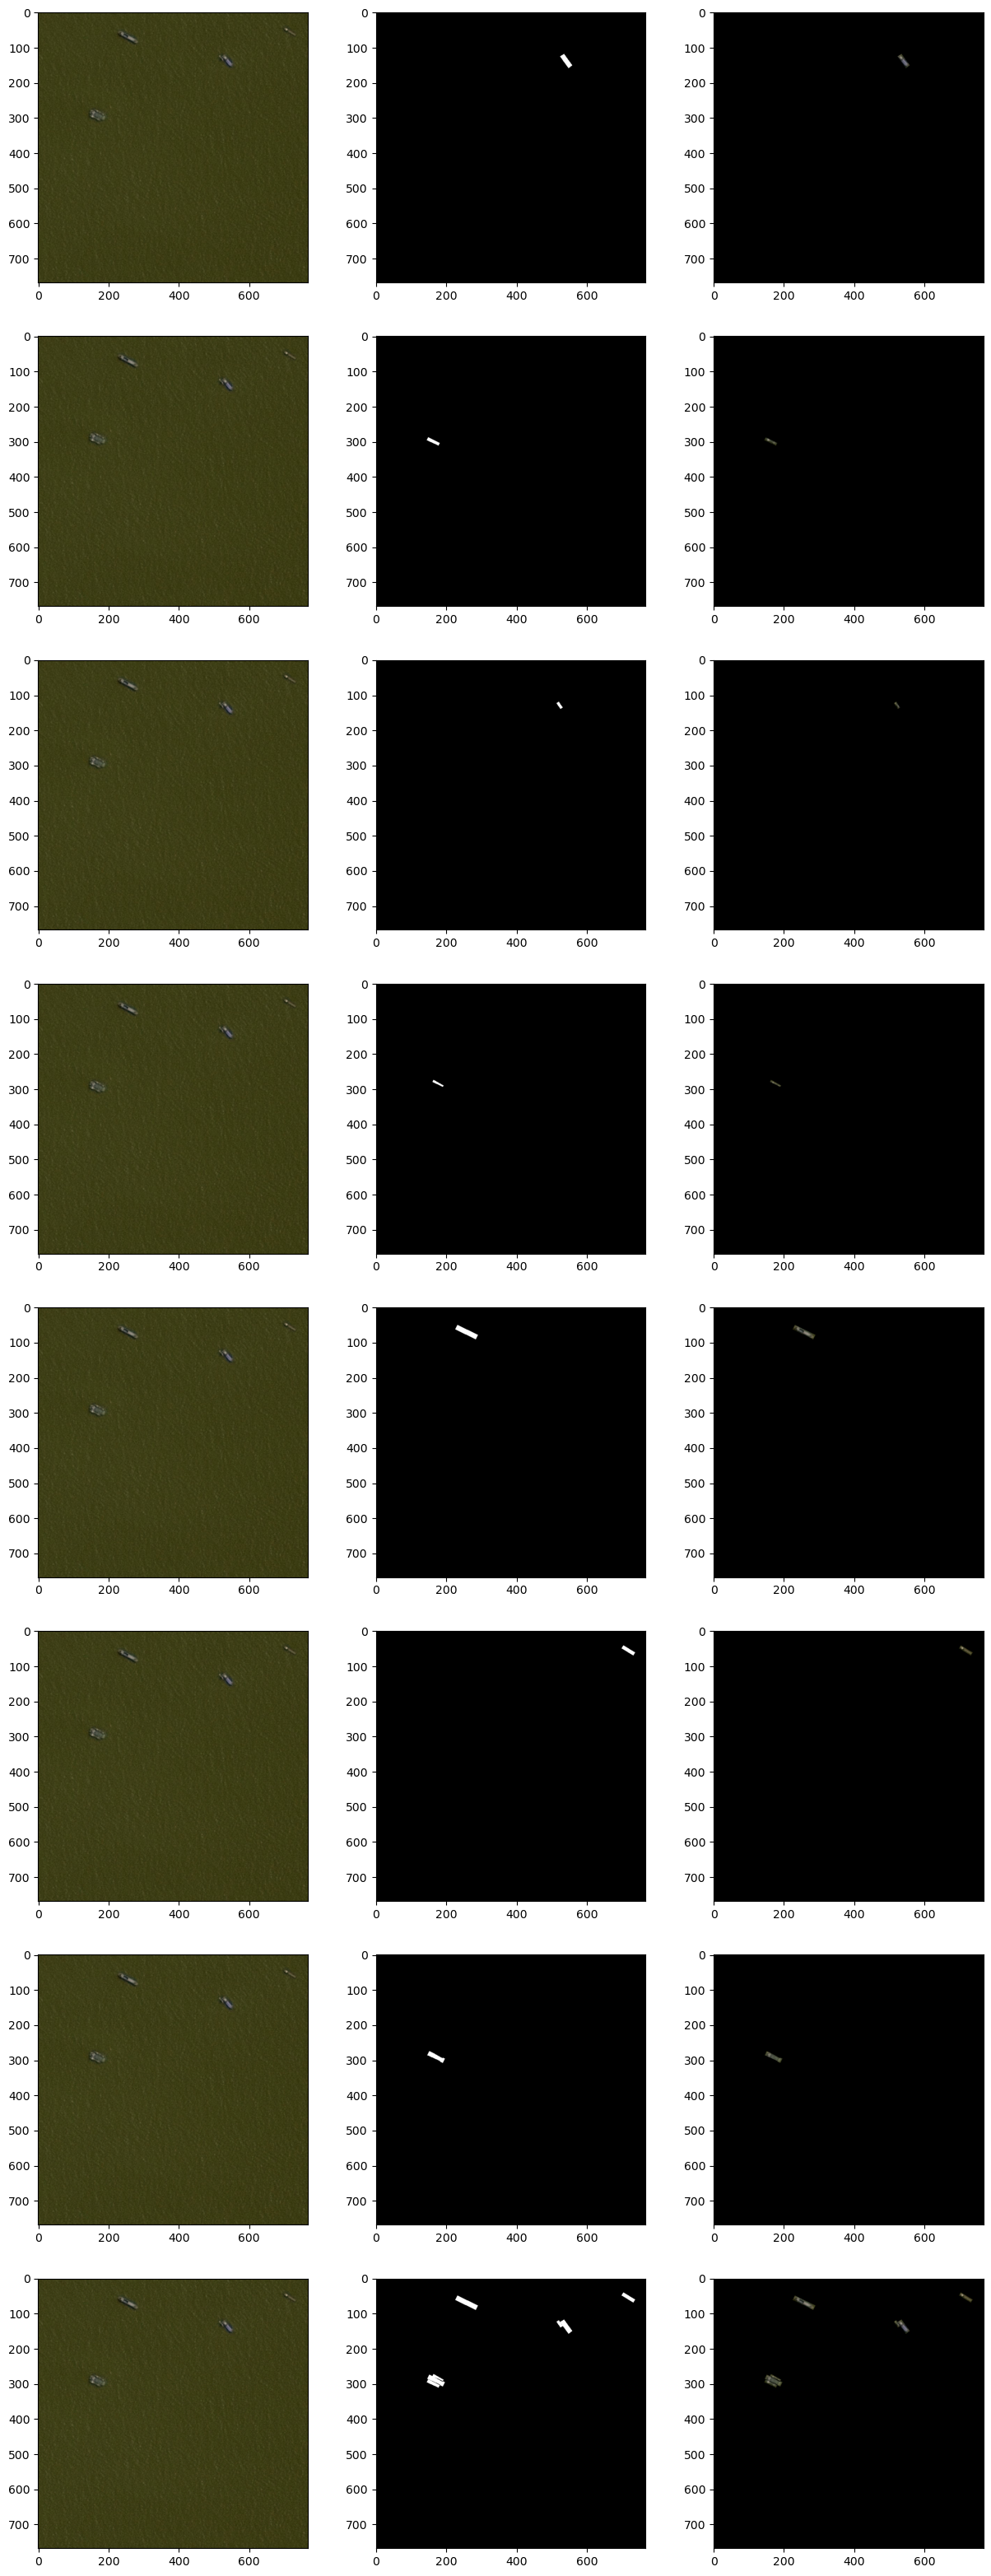

,ImageId,EncodedPixels,ImageHeight,ImageWidth,ShipAreaPercentage,ShipCount
60,00113a75c.jpg,401790 1 402557 3 403325 5 404092 7 404859 9 4...,768,768,0.094774,1
61,00113a75c.jpg,110888 2 111654 4 112420 7 113186 9 113953 11 ...,768,768,0.056458,1
62,00113a75c.jpg,394109 1 394876 4 395644 5 396411 8 397178 10 ...,768,768,0.027296,1
63,00113a75c.jpg,123159 1 123925 4 124691 6 125458 8 126227 7 1...,768,768,0.032383,1
64,00113a75c.jpg,172862 2 173628 4 174394 7 175160 9 175926 12 ...,768,768,0.158522,1
65,00113a75c.jpg,536114 1 536880 4 537646 6 538413 8 539179 10 ...,768,768,0.068834,1
66,00113a75c.jpg,111647 1 112413 3 113179 6 113945 8 114711 10 ...,768,768,0.104099,1


In [12]:
image_id = '00113a75c.jpg'
show_image_with_encoded_pixels(image_id)
segmentations[segmentations['ImageId'] == image_id]

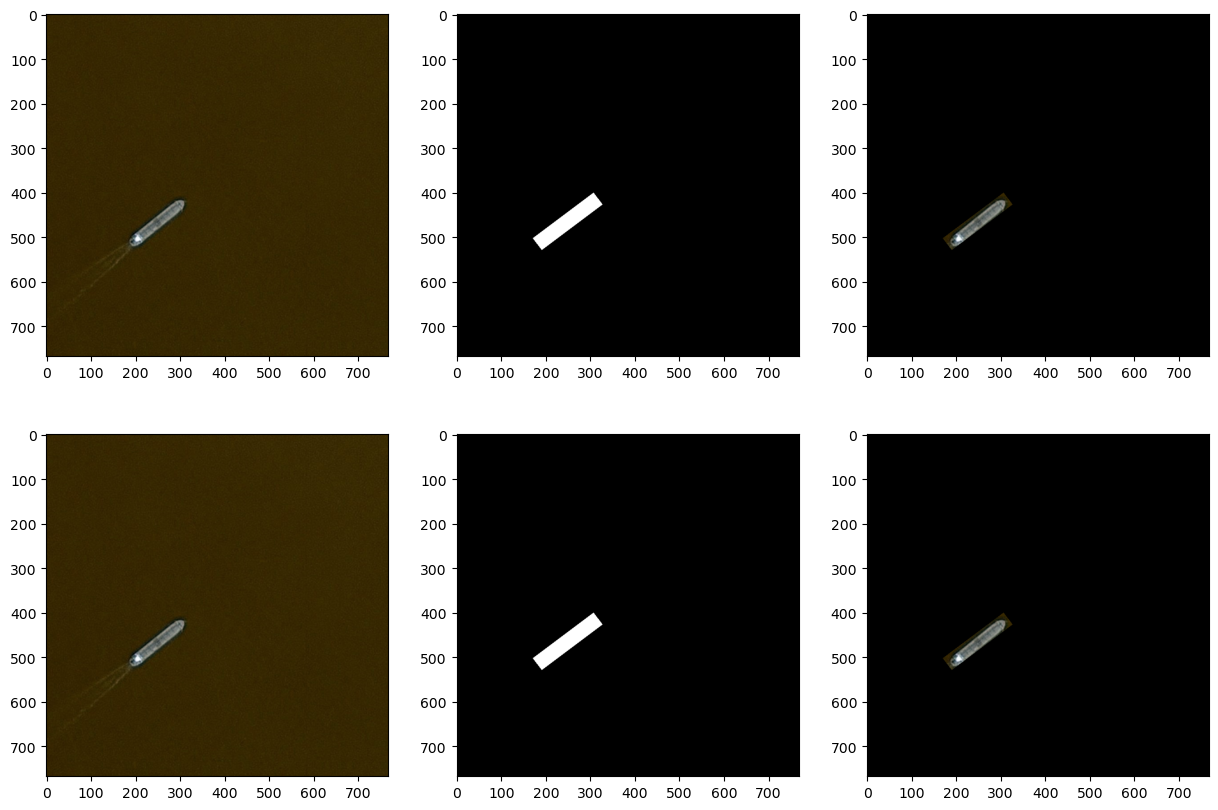

,ImageId,EncodedPixels,ImageHeight,ImageWidth,ShipAreaPercentage,ShipCount
71,001234638.jpg,131064 1 131831 3 132599 5 133366 7 134133 9 1...,768,768,0.973002,1


In [13]:
image_id = '001234638.jpg'
show_image_with_encoded_pixels(image_id)
segmentations[segmentations['ImageId'] == image_id]

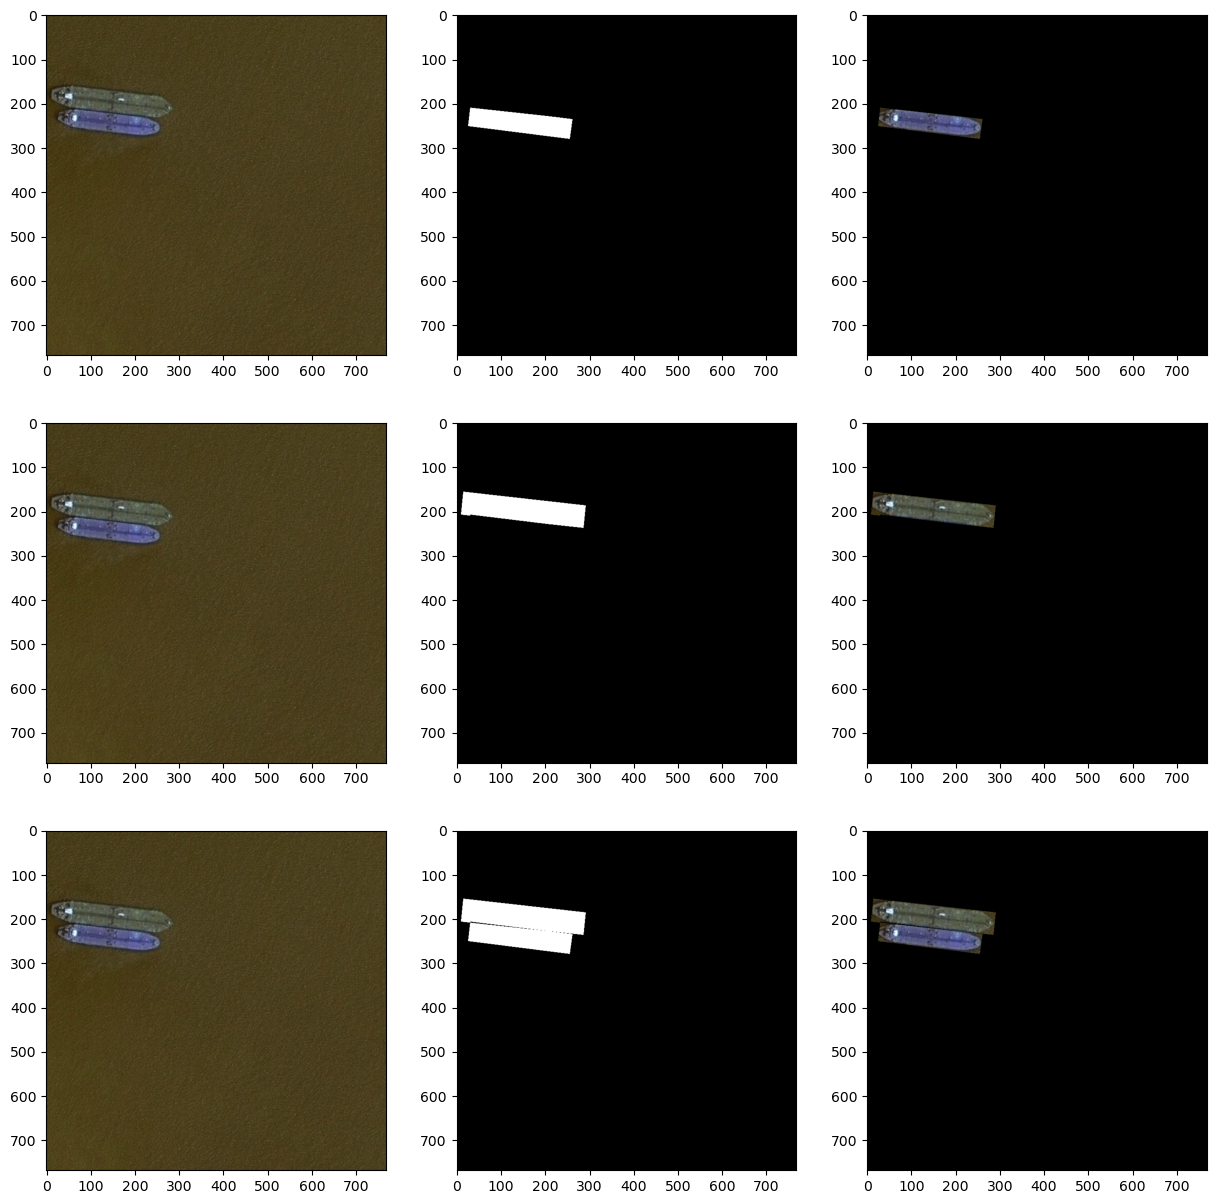

,ImageId,EncodedPixels,ImageHeight,ImageWidth,ShipAreaPercentage,ShipCount
203177,e0a5b275f.jpg,19447 5 20207 13 20966 22 21725 31 22485 40 23...,768,768,1.731703,1
203178,e0a5b275f.jpg,7114 6 7872 16 8630 26 9388 36 10146 46 10908 ...,768,768,2.409871,1


In [14]:
image_id = 'e0a5b275f.jpg'
show_image_with_encoded_pixels(image_id)
segmentations[segmentations['ImageId'] == image_id]

All the ship segment labels in the training dataset are bounding boxes (rectangles). Moreover the ships in the images have a slightly different shape from a rectangular one.

Also there are images in which the ships are side by side, and their segments have a common border.

## EDA results
It was found that most of the images (78%) do not contain ships. All the ships in the images take up a very small part (approximately 0,1%), the pictures contain a lot of background. Also, target segmentation for labeled pictures consists of bounding boxes (rectangles). Ships do not intersect, but their borders in some images have adjacent borders.